# Serialization & Sharing: Save, Load, Export, Reproduce

JAXSR provides multiple serialization formats so you can:

- **Save and load** models, basis libraries, and DOE studies
- **Share** results with collaborators (even those without JAXSR)
- **Deploy** models as pure NumPy callables (no JAX dependency)
- **Reproduce** analyses from saved artifacts
- **Export** equations to LaTeX, SymPy, or callable functions

## What Can Be Serialized?

| Object | Format | File Extension | Contains |
|--------|--------|---------------|----------|
| `SymbolicRegressor` | JSON | `.json` | Model expression, coefficients, metrics, basis config |
| `BasisLibrary` | JSON | `.json` | All basis function definitions (except custom/parametric) |
| `DOEStudy` | ZIP | `.jaxsr` | Study metadata, designs, observations, fitted model, history |

In [1]:
import json
import os
import tempfile

import jax.numpy as jnp
import numpy as np

from jaxsr import BasisLibrary, DOEStudy, SymbolicRegressor, fit_symbolic

np.random.seed(42)

# We'll save everything to a temp directory
SAVE_DIR = tempfile.mkdtemp(prefix="jaxsr_serial_")
print(f"Save directory: {SAVE_DIR}")

Save directory: /var/folders/sj/cb6cr7_s45d67mqjmsfx8mt80000gn/T/jaxsr_serial_qbggtijz


## 1. Saving and Loading Models

A `SymbolicRegressor` can be saved to JSON and loaded back with full fidelity —
the loaded model produces identical predictions.

In [2]:
# Fit a model
n = 80
X = np.column_stack([
    np.random.uniform(0, 5, n),
    np.random.uniform(0, 5, n),
])
y = 2.5 * X[:, 0] + 1.2 * X[:, 0] * X[:, 1] - 0.8 * X[:, 1]**2 + 0.3 * np.random.randn(n)

library = (
    BasisLibrary(n_features=2, feature_names=["x1", "x2"])
    .add_constant()
    .add_linear()
    .add_polynomials(max_degree=3)
    .add_interactions(max_order=2)
)

model = SymbolicRegressor(
    basis_library=library, max_terms=5, information_criterion="bic"
)
model.fit(jnp.array(X), jnp.array(y))
print(f"Fitted model: {model.expression_}")
print(f"R² = {model.metrics_['r2']:.6f}")

Fitted model: y = 1.391*x1^2 - 0.06529*x2^3 + 1.092*x1*x2 - 0.1829*x1^3 - 0.4371*x2^2
R² = 0.994862


Parameter Significance (95% CI):
             Term   Estimate   Std Err        t    p-value 95% CI
  ---------------------------------------------------------------------------
             x1^2     1.3907    0.0510    27.27   0.00e+00 [1.2891, 1.4922] ***
             x2^3    -0.0653    0.0106    -6.14   3.57e-08 [-0.0865, -0.0441] ***
            x1*x2     1.0916    0.0320    34.09   0.00e+00 [1.0278, 1.1553] ***
             x1^3    -0.1829    0.0108   -16.99   0.00e+00 [-0.2043, -0.1614] ***
             x2^2    -0.4371    0.0480    -9.10   9.66e-14 [-0.5328, -0.3414] ***
  --- *** p<0.001, ** p<0.01, * p<0.05


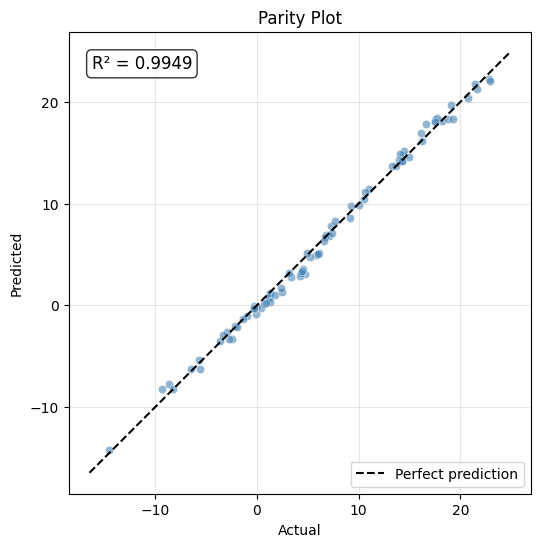

In [3]:
# Quality of fit and parameter significance
import matplotlib.pyplot as plt
from scipy import stats as sp_stats

from jaxsr.plotting import plot_parity

intervals = model.coefficient_intervals(alpha=0.05)
n, k = len(np.asarray(y)), len(model.selected_features_)
df = n - k

print("Parameter Significance (95% CI):")
print(f"  {'Term':>15s} {'Estimate':>10s} {'Std Err':>9s} {'t':>8s} {'p-value':>10s} 95% CI")
print("  " + "-" * 75)
for name, (est, lo, hi, se) in intervals.items():
    t_val = est / se if abs(se) > 1e-15 else float("inf")
    p_val = float(2 * (1 - sp_stats.t.cdf(abs(t_val), df))) if df > 0 else 0.0
    sig = "***" if p_val < 0.001 else ("**" if p_val < 0.01 else ("*" if p_val < 0.05 else ""))
    print(f"  {name:>15s} {est:10.4f} {se:9.4f} {t_val:8.2f} {p_val:10.2e} [{lo:.4f}, {hi:.4f}] {sig}")
print("  --- *** p<0.001, ** p<0.01, * p<0.05")

# Parity plot
y_pred_check = model.predict(jnp.array(X))
fig, ax = plt.subplots(figsize=(6, 6))
plot_parity(jnp.array(y), y_pred_check, ax=ax, title="Parity Plot")
plt.show()

In [4]:
# Save the model
model_path = os.path.join(SAVE_DIR, "model.json")
model.save(model_path)
print(f"Model saved to: {model_path}")
print(f"File size: {os.path.getsize(model_path)} bytes")

# Load it back
loaded_model = SymbolicRegressor.load(model_path)
print(f"\nLoaded model: {loaded_model.expression_}")

# Verify predictions match
X_test = np.random.uniform(0, 5, (10, 2))
y_orig = model.predict(jnp.array(X_test))
y_loaded = loaded_model.predict(jnp.array(X_test))
max_diff = float(jnp.max(jnp.abs(y_orig - y_loaded)))
print(f"\nMax prediction difference: {max_diff:.2e}")
assert max_diff < 1e-6, "Predictions should match!"
print("Predictions match perfectly.")

Model saved to: /var/folders/sj/cb6cr7_s45d67mqjmsfx8mt80000gn/T/jaxsr_serial_qbggtijz/model.json
File size: 2787 bytes

Loaded model: y = 1.391*x1^2 - 0.06529*x2^3 + 1.092*x1*x2 - 0.1829*x1^3 - 0.4371*x2^2



Max prediction difference: 0.00e+00
Predictions match perfectly.


In [5]:
# Peek inside the JSON file
with open(model_path) as f:
    data = json.load(f)

print("Model JSON structure:")
print(f"  Top-level keys: {list(data.keys())}")

# The model JSON nests data under 'config', 'basis_library', 'result', etc.
if "result" in data:
    result_keys = list(data["result"].keys())
    print(f"  result keys: {result_keys}")
    print(f"  Selected names: {data['result'].get('selected_names', 'N/A')}")
    print(f"  n_coefficients: {len(data['result'].get('coefficients', []))}")
if "config" in data:
    print(f"  config keys: {list(data['config'].keys())}")
if "basis_library" in data:
    print(f"  basis_library keys: {list(data['basis_library'].keys())}")

Model JSON structure:
  Top-level keys: ['config', 'basis_library', 'result', 'constraints']
  result keys: ['coefficients', 'selected_indices', 'selected_names', 'mse', 'complexity', 'aic', 'bic', 'aicc', 'n_samples']
  Selected names: ['x1^2', 'x2^3', 'x1*x2', 'x1^3', 'x2^2']
  n_coefficients: 5
  config keys: ['max_terms', 'strategy', 'information_criterion', 'cv_folds', 'regularization', 'random_state', 'param_optimizer', 'param_optimization_budget']
  basis_library keys: ['n_features', 'feature_names', 'feature_bounds', 'basis_functions']


## 2. Saving and Loading Basis Libraries

A `BasisLibrary` can be saved and loaded independently. This is useful when you
want to reuse the same candidate function set across multiple datasets.

**Limitation:** Custom functions (`add_custom`) and parametric functions
(`add_parametric`) involve Python callables that cannot be serialized.
They raise a `ValueError` on load and must be re-added manually.

In [6]:
# Create a library
library = (
    BasisLibrary(n_features=3, feature_names=["T", "P", "flow"])
    .add_constant()
    .add_linear()
    .add_polynomials(max_degree=2)
    .add_interactions(max_order=2)
    .add_transcendental(funcs=["log", "exp", "sqrt"])
)
print(f"Library: {len(library)} basis functions")

# Save
lib_path = os.path.join(SAVE_DIR, "basis_library.json")
library.save(lib_path)
print(f"Saved to: {lib_path} ({os.path.getsize(lib_path)} bytes)")

# Load
loaded_lib = BasisLibrary.load(lib_path)
print(f"\nLoaded library: {len(loaded_lib)} basis functions")
print(f"Names match: {library.names == loaded_lib.names}")

# Verify evaluation matches
X_check = np.random.uniform(0.1, 5, (5, 3))
Phi_orig = library.evaluate(jnp.array(X_check))
Phi_loaded = loaded_lib.evaluate(jnp.array(X_check))
max_diff = float(jnp.max(jnp.abs(Phi_orig - Phi_loaded)))
print(f"Max evaluation difference: {max_diff:.2e}")

Library: 19 basis functions
Saved to: /var/folders/sj/cb6cr7_s45d67mqjmsfx8mt80000gn/T/jaxsr_serial_qbggtijz/basis_library.json (4354 bytes)

Loaded library: 19 basis functions
Names match: True


Max evaluation difference: 0.00e+00


## 3. DOE Study Archives (`.jaxsr` files)

A `DOEStudy` saves everything — metadata, factor definitions, experimental
designs, all observations (with timestamps and notes), and the fitted model —
into a single `.jaxsr` ZIP archive.

This is the most portable format: share the `.jaxsr` file and your collaborator
can pick up exactly where you left off.

In [7]:
# Create a study with multiple rounds of data
study = DOEStudy(
    name="heat_exchanger",
    factor_names=["Re", "Pr"],
    bounds=[(5000, 50000), (0.7, 50)],
    description="Nusselt number correlation for heat exchanger design",
)

# Round 1: initial design
X1 = study.create_design(method="latin_hypercube", n_points=15, random_state=42)
y1 = 0.023 * X1[:, 0]**0.8 * X1[:, 1]**0.4 + np.random.randn(15) * 2
study.add_observations(X1, y1, notes="Round 1: initial screening")

# Fit
model = study.fit(max_terms=5)
print(f"Model: {model.expression_}")
print(f"R² = {model.metrics_['r2']:.4f}")

# Round 2: additional data
X2 = np.random.uniform([5000, 0.7], [50000, 50], size=(5, 2))
y2 = 0.023 * X2[:, 0]**0.8 * X2[:, 1]**0.4 + np.random.randn(5) * 2
study.add_observations(X2, y2, notes="Round 2: gap-filling experiments")
model = study.fit(max_terms=5)

# Save
study_path = os.path.join(SAVE_DIR, "heat_exchanger.jaxsr")
study.save(study_path)
print(f"\nStudy saved to: {study_path}")
print(f"File size: {os.path.getsize(study_path)} bytes")

/Users/jkitchin/Dropbox/projects/jaxsr/src/jaxsr/study.py:572: UserWarning: Removing 1 basis functions with non-finite values
  model.fit(self._X_observed, self._y_observed)


Model: y = 0.0002308*Re*Pr + 0.8274*sqrt(Re) - 0.0005804*Pr^3
R² = 0.9757



Study saved to: /var/folders/sj/cb6cr7_s45d67mqjmsfx8mt80000gn/T/jaxsr_serial_qbggtijz/heat_exchanger.jaxsr
File size: 2498 bytes


In [8]:
# Load the study on a different machine (or in a new session)
loaded_study = DOEStudy.load(study_path)

print(loaded_study.summary())
print(f"\nTotal observations: {loaded_study.n_observations}")
print(f"Is fitted: {loaded_study.is_fitted}")

DOE Study: heat_exchanger
Description: Nusselt number correlation for heat exchanger design
Factors: Re, Pr
Bounds: [(5000, 50000), (0.7, 50)]

Design: 15 points (15 completed, 0 pending)
Design method: latin_hypercube
Observations: 20

Model: y = 0.0002248*Re*Pr + 0.8462*sqrt(Re) - 0.0004588*Pr^3
  MSE: 390.63
  AIC: 182.1128
  Terms: 3

Iterations: 2
  Round 1: +15 points → y = 0.0002308*Re*Pr + 0.8274*sqrt(Re) - 0.0005804*Pr^3 (Round 1: initial screening)
  Round 2: +5 points → y = 0.0002248*Re*Pr + 0.8462*sqrt(Re) - 0.0004588*Pr^3 (Round 2: gap-filling experiments)

Created: 2026-02-07T14:42:35.965538+00:00
Modified: 2026-02-07T14:42:37.648621+00:00

Total observations: 20
Is fitted: True


In [9]:
# A collaborator can continue the study: suggest, add data, refit
loaded_study = DOEStudy.load(study_path)

# Suggest next experiments
next_pts = loaded_study.suggest_next(n_points=3, strategy="space_filling")
print("Collaborator's next experiments:")
for i, pt in enumerate(next_pts):
    print(f"  Run {i+1}: Re = {pt[0]:.0f}, Pr = {pt[1]:.2f}")

# They run the experiments and add data
y_new = 0.023 * next_pts[:, 0]**0.8 * next_pts[:, 1]**0.4 + np.random.randn(3) * 2
loaded_study.add_observations(next_pts, y_new, notes="Collaborator round")
loaded_study.fit(max_terms=5)
loaded_study.save(study_path)  # overwrite with updated study

print(f"\nUpdated study: {loaded_study.n_observations} total observations")

Collaborator's next experiments:
  Run 1: Re = 11107, Pr = 2.38
  Run 2: Re = 5267, Pr = 2.58
  Run 3: Re = 6075, Pr = 1.52



Updated study: 23 total observations


## 4. Exporting Models for Deployment

Once you have a good model, you may want to use it in production without
requiring JAX or JAXSR as dependencies.

In [10]:
# Refit our original model
X = np.column_stack([
    np.random.uniform(0, 5, 80),
    np.random.uniform(0, 5, 80),
])
y = 2.5 * X[:, 0] - 0.8 * X[:, 1]**2 + 0.3 * np.random.randn(80)
model = fit_symbolic(jnp.array(X), jnp.array(y), feature_names=["x1", "x2"], max_terms=4)

print(f"Model: {model.expression_}")
print()

# --- Export 1: Pure NumPy callable ---
predict_fn = model.to_callable()

# This function uses only NumPy — no JAX needed
X_new = np.array([[1.0, 2.0], [3.0, 4.0]])
y_pred = predict_fn(X_new)
print(f"NumPy callable predictions: {y_pred}")
print(f"Type: {type(predict_fn)}")
print()

# --- Export 2: SymPy expression ---
sympy_expr = model.to_sympy()
print(f"SymPy: {sympy_expr}")
print(f"Type: {type(sympy_expr)}")
print()

# SymPy enables symbolic manipulation
import sympy

x1, x2 = sympy.symbols("x1 x2")
derivative = sympy.diff(sympy_expr, x1)
print(f"d/dx1: {derivative}")
print()

# --- Export 3: LaTeX ---
latex = model.to_latex()
print(f"LaTeX: ${latex}$")

Model: y = 0.001248*x2^3 + 2.53*x1 - 0.7915*x2^2 - 0.0273*x1*x2

NumPy callable predictions: [-0.68045306 -5.32114834]
Type: <class 'function'>



SymPy: -0.0273035187274218*x1*x2 + 2.53005385398865*x1 - 0.79147070646286*x2**2.0 + 0.00124786922242492*x2**3.0
Type: <class 'sympy.core.add.Add'>

d/dx1: 2.53005385398865 - 0.0273035187274218*x2

LaTeX: $- 0.0273035187274218 x_{1} x_{2} + 2.53005385398865 x_{1} - 0.79147070646286 x_{2}^{2.0} + 0.00124786922242492 x_{2}^{3.0}$


In [11]:
# Deployment pattern: save the callable as a standalone module
# This is how you'd integrate into a production system

deploy_code = f'''\
"""Auto-generated prediction function from JAXSR.

Model: {model.expression_}
R² = {model.metrics_["r2"]:.6f}
Generated with JAXSR v0.1.0
"""
import numpy as np

# Coefficients: {dict(zip(model.selected_features_, [float(c) for c in model.coefficients_], strict=False))}

def predict(X):
    """Predict y from X array of shape (n_samples, 2).

    Features: x1 (column 0), x2 (column 1)
    """
    X = np.asarray(X)
    if X.ndim == 1:
        X = X.reshape(1, -1)
    # Use the exported callable
    from jaxsr import SymbolicRegressor
    model = SymbolicRegressor.load("{model_path}")
    return np.asarray(model.predict(X))
'''

print("Example deployment module:")
print(deploy_code[:300] + "...")
print()
print("For zero-dependency deployment, use model.to_callable() directly.")
print("The callable is a pure Python/NumPy function with no JAX dependency.")

Example deployment module:
"""Auto-generated prediction function from JAXSR.

Model: y = 0.001248*x2^3 + 2.53*x1 - 0.7915*x2^2 - 0.0273*x1*x2
R² = 0.998178
Generated with JAXSR v0.1.0
"""
import numpy as np

# Coefficients: {'x2^3': 0.0012478692224249244, 'x1': 2.5300538539886475, 'x2^2': -0.7914707064628601, 'x1*x2': -0.0273...

For zero-dependency deployment, use model.to_callable() directly.
The callable is a pure Python/NumPy function with no JAX dependency.


## 5. Reproducibility Checklist

To fully reproduce a JAXSR analysis, save these artifacts:

In [12]:
# Complete reproducibility: save everything
repro_dir = os.path.join(SAVE_DIR, "reproducible")
os.makedirs(repro_dir, exist_ok=True)

# 1. Raw data
np.savez(
    os.path.join(repro_dir, "data.npz"),
    X=X, y=y,
)
print("[1] Saved raw data → data.npz")

# 2. Basis library configuration
library = (
    BasisLibrary(n_features=2, feature_names=["x1", "x2"])
    .add_constant()
    .add_linear()
    .add_polynomials(max_degree=3)
    .add_interactions(max_order=2)
)
library.save(os.path.join(repro_dir, "library.json"))
print("[2] Saved basis library → library.json")

# 3. Fitted model
model.save(os.path.join(repro_dir, "model.json"))
print("[3] Saved fitted model → model.json")

# 4. Metadata
metadata = {
    "jaxsr_version": "0.1.0",
    "random_seed": 42,
    "strategy": "greedy_forward",
    "information_criterion": "bic",
    "max_terms": 4,
    "expression": model.expression_,
    "metrics": {k: float(v) for k, v in model.metrics_.items()},
}
with open(os.path.join(repro_dir, "metadata.json"), "w") as f:
    json.dump(metadata, f, indent=2)
print("[4] Saved metadata → metadata.json")

print(f"\nReproducibility package: {repro_dir}/")
for fname in sorted(os.listdir(repro_dir)):
    size = os.path.getsize(os.path.join(repro_dir, fname))
    print(f"  {fname:25s}  {size:>8} bytes")

[1] Saved raw data → data.npz
[2] Saved basis library → library.json
[3] Saved fitted model → model.json
[4] Saved metadata → metadata.json

Reproducibility package: /var/folders/sj/cb6cr7_s45d67mqjmsfx8mt80000gn/T/jaxsr_serial_qbggtijz/reproducible/
  data.npz                       2410 bytes
  library.json                   1765 bytes
  metadata.json                   384 bytes
  model.json                     4771 bytes


In [13]:
# Reproduce the analysis from saved artifacts
print("Reproducing analysis from saved artifacts...")
print("=" * 50)

# Load data
data = np.load(os.path.join(repro_dir, "data.npz"))
X_repro, y_repro = data["X"], data["y"]

# Load library and refit
lib_repro = BasisLibrary.load(os.path.join(repro_dir, "library.json"))
model_repro = SymbolicRegressor(
    basis_library=lib_repro, max_terms=4, information_criterion="bic"
)
model_repro.fit(jnp.array(X_repro), jnp.array(y_repro))

# Or just load the saved model directly
model_direct = SymbolicRegressor.load(os.path.join(repro_dir, "model.json"))

print(f"Refit model:  {model_repro.expression_}")
print(f"Loaded model: {model_direct.expression_}")
print(f"\nExpressions match: {model_repro.expression_ == model_direct.expression_}")

# Verify predictions
X_test = np.random.uniform(0, 5, (5, 2))
y1 = model_repro.predict(jnp.array(X_test))
y2 = model_direct.predict(jnp.array(X_test))
print(f"Max prediction difference: {float(jnp.max(jnp.abs(y1 - y2))):.2e}")

Reproducing analysis from saved artifacts...
Refit model:  y = 0.001248*x2^3 + 2.53*x1 - 0.7915*x2^2 - 0.0273*x1*x2
Loaded model: y = 0.001248*x2^3 + 2.53*x1 - 0.7915*x2^2 - 0.0273*x1*x2

Expressions match: True
Max prediction difference: 0.00e+00


## 6. What Cannot Be Serialized

Some objects involve Python callables that cannot be saved to JSON:

| Feature | Serializable? | Workaround |
|---------|--------------|------------|
| Standard basis (poly, transcendental) | Yes | Reconstructed from config |
| Custom basis (`add_custom`) | **No** | Re-add manually after loading |
| Parametric basis (`add_parametric`) | **No** | Re-add manually after loading |
| Constraints | **No** | Reconstruct from code |
| Fitted coefficients & metrics | Yes | Stored in model JSON |
| Pareto front | Yes | Stored in model JSON |

For parametric models (like the Langmuir example), save the model JSON
for predictions, but keep the fitting script for full reproducibility.

In [14]:
# Clean up temporary files
import shutil

shutil.rmtree(SAVE_DIR)
print(f"Cleaned up: {SAVE_DIR}")

Cleaned up: /var/folders/sj/cb6cr7_s45d67mqjmsfx8mt80000gn/T/jaxsr_serial_qbggtijz


## Summary

| Task | Method |
|------|--------|
| Save a model | `model.save("model.json")` |
| Load a model | `SymbolicRegressor.load("model.json")` |
| Save a basis library | `library.save("lib.json")` |
| Load a basis library | `BasisLibrary.load("lib.json")` |
| Save a DOE study | `study.save("study.jaxsr")` |
| Load a DOE study | `DOEStudy.load("study.jaxsr")` |
| Deploy without JAX | `predict_fn = model.to_callable()` |
| Export to SymPy | `expr = model.to_sympy()` |
| Export to LaTeX | `latex = model.to_latex()` |

### Best Practices

1. **For DOE workflows**, use `.jaxsr` files — they capture the entire study lifecycle
2. **For sharing models**, use `model.save()` — recipients can predict without refitting
3. **For deployment**, use `model.to_callable()` — zero-dependency NumPy function
4. **For reproducibility**, save data + library + model + metadata together
5. **For publications**, use `model.to_latex()` and `model.to_sympy()`